# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **Erasmus Scholarship Grant Prediction Engine** |

# II. Notebook Target Definition

_Insert Text Here_

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import os
import pandas as pd
import pickle
import seaborn as sns
import setuptools

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## III.B. Import Data

In [2]:
X_train = pd.read_pickle('../../data/processed/X_train.pkl')
X_test = pd.read_pickle('../../data/processed/X_test.pkl')
y_train = pd.read_pickle('../../data/processed/y_train.pkl')
y_test = pd.read_pickle('../../data/processed/y_test.pkl')

In [3]:
X_train.head()

,COUNTRIES,UNIVERSITIES,FACULTIES,DEPARTMENTS,EXAM SCORE
121,0.403265,0.469954,0.410333,0.529092,82.62
145,0.444305,0.402256,0.370182,0.370836,81.07
295,0.473520,0.391327,0.506751,0.381131,69.28
58,0.473520,0.514303,0.334078,0.391489,87.58
155,0.392101,0.464297,0.448575,0.439951,80.33


In [4]:
X_test.head()

,COUNTRIES,UNIVERSITIES,FACULTIES,DEPARTMENTS,EXAM SCORE
188,0.403265,0.372452,0.370182,0.338675,78.20
101,0.403265,0.521442,0.334078,0.402803,84.04
202,0.476620,0.420356,0.334078,0.449291,77.55
261,0.444305,0.451763,0.334078,0.402803,73.18
133,0.403265,0.372452,0.334078,0.391489,82.05


In [5]:
y_train.head()

121    1
145    0
295    0
58     1
155    0
Name: GRANT, dtype: int64

In [6]:
y_test.head()

188    0
101    1
202    0
261    0
133    0
Name: GRANT, dtype: int64

# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [7]:
X_train.shape, X_test.shape

((238, 5), (103, 5))

In [8]:
y_train.shape, y_test.shape

((238,), (103,))

## IV.B. Data Information Inspection

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 121 to 51
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   COUNTRIES     238 non-null    float64
 1   UNIVERSITIES  238 non-null    float64
 2   FACULTIES     238 non-null    float64
 3   DEPARTMENTS   238 non-null    float64
 4   EXAM SCORE    238 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 188 to 315
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   COUNTRIES     103 non-null    float64
 1   UNIVERSITIES  103 non-null    float64
 2   FACULTIES     103 non-null    float64
 3   DEPARTMENTS   103 non-null    float64
 4   EXAM SCORE    103 non-null    float64
dtypes: float64(5)
memory usage: 4.8 KB


In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 238 entries, 121 to 51
Series name: GRANT
Non-Null Count  Dtype
--------------  -----
238 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 103 entries, 188 to 315
Series name: GRANT
Non-Null Count  Dtype
--------------  -----
103 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


## IV.C. Model Training with MLFlow

### IV.C.1. MLFlow Setup

In [13]:
mlflow.set_tracking_uri('../../models')
mlflow.set_experiment("Erasmus Scholarship Grant Prediction Engine")
default_params = {"n_estimators": 100, "random_state": 777}
custom_params = {"n_estimators": 150, "max_depth": 10, "random_state": 777}
param_grid = {"n_estimators": [50, 100, 150], "max_depth": [None, 10, 20]}

Traceback (most recent call last):
  File "C:\Users\harde\anaconda3\envs\pacmann\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harde\anaconda3\envs\pacmann\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harde\anaconda3\envs\pacmann\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harde\anaconda3\envs\pacmann\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_helper
    result = read_yaml(root, file_name)
        

In [14]:
def run_experiment(X_train, X_test, y_train, y_test, params, run_name):
    with mlflow.start_run(run_name=run_name):
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        tree = model.estimators_[0]
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error: {mse}")
        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        mlflow.sklearn.log_model(model, "random_forest_model")
        output_dir = "../../reports/figures/"
        os.makedirs(output_dir, exist_ok=True)
        feature_importance = model.feature_importances_
        features = X_train.columns
        importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
        sns.barplot(x="Importance", y="Feature", data=importance_df.sort_values(by="Importance", ascending=False))
        plt.title("Feature Importance")
        feature_importance_path = os.path.join(output_dir, f"feature_importance_{run_name}.png")
        plt.savefig(feature_importance_path)
        plt.show()
        mlflow.log_artifact(feature_importance_path)
        dot_data = export_graphviz(tree, out_file=None,
                                   feature_names=X_train.columns,
                                   filled=True, rounded=True,
                                   special_characters=True)
        dot_file_path = os.path.join(output_dir, f"tree_{run_name}.dot")
        with open(dot_file_path, "w") as file:
            file.write(dot_data)
        mlflow.log_artifact(dot_file_path)
        graph = graphviz.Source(dot_data)
        display(graph)
        tree_png_path = os.path.join(output_dir, f"tree_{run_name}.png")
        graph.render(filename=tree_png_path, format="png")
        mlflow.log_artifact(f"{tree_png_path}.png")
        model_path = f'../../models/random_forest_model_{run_name}.pkl'
        with open(model_path, 'wb') as file:
            pickle.dump(model, file)
        mlflow.log_artifact(model_path)

### IV.C.2. Untouched Model Experimentation

Mean Squared Error: 0.04075533980582524


C:\Users\harde\anaconda3\envs\pacmann\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


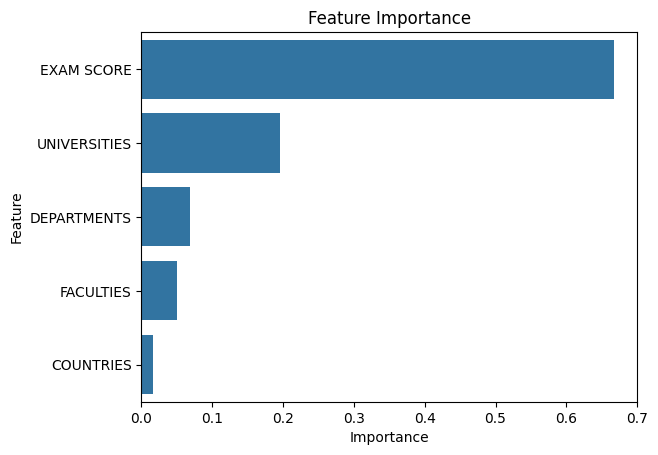

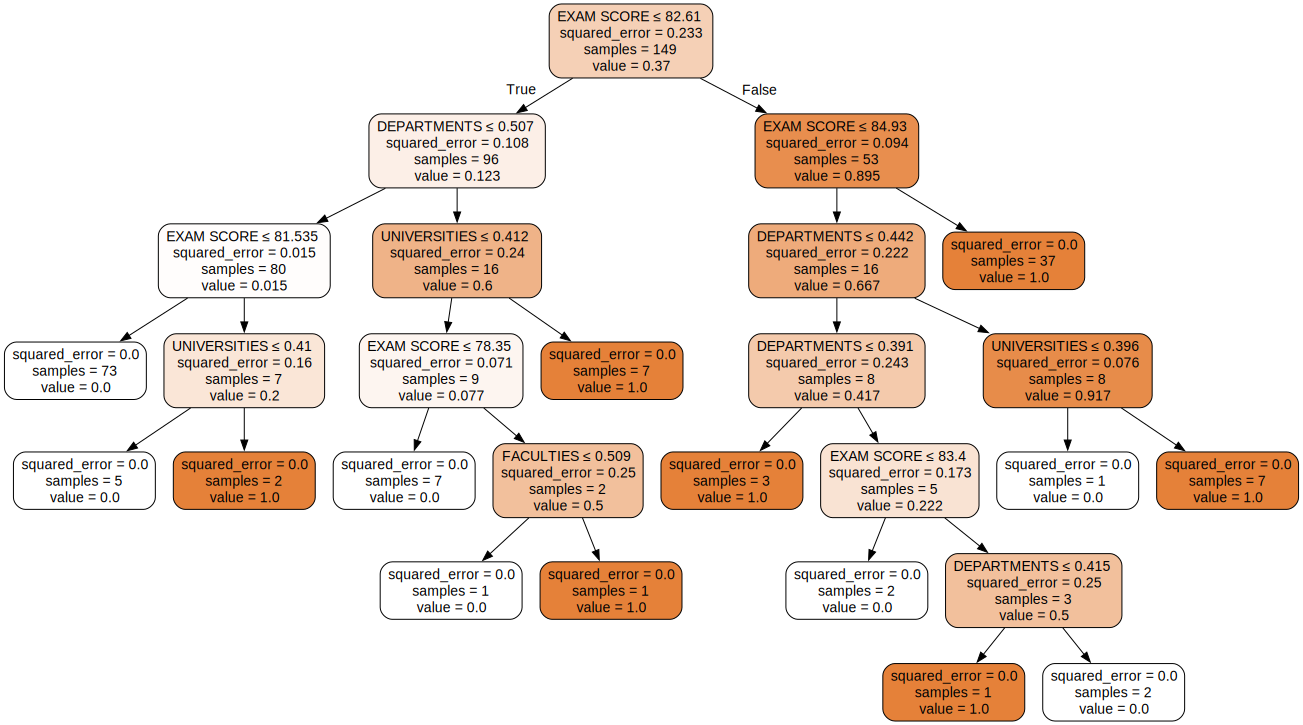

In [15]:
run_experiment(X_train, X_test, y_train, y_test, default_params, "Untouched Model")

### IV.C.3. Custom Settings Model Experimentation

Mean Squared Error: 0.04118446601941748


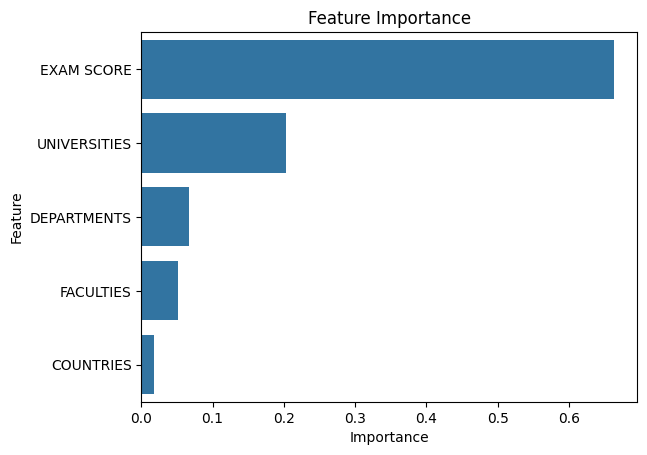

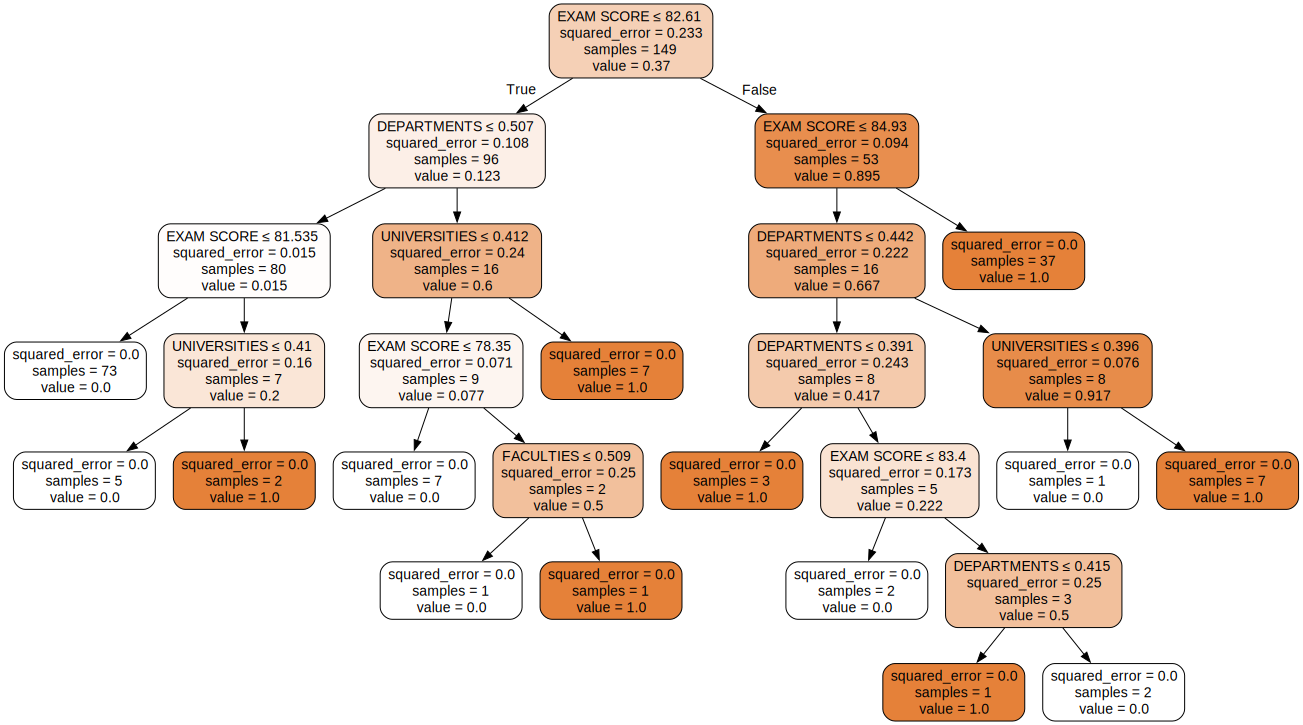

In [16]:
run_experiment(X_train, X_test, y_train, y_test, custom_params, "Custom Settings Model")

### IV.C.4. Hyperparameter Tuned-Model Experimentation

Mean Squared Error: 0.042220496224379726


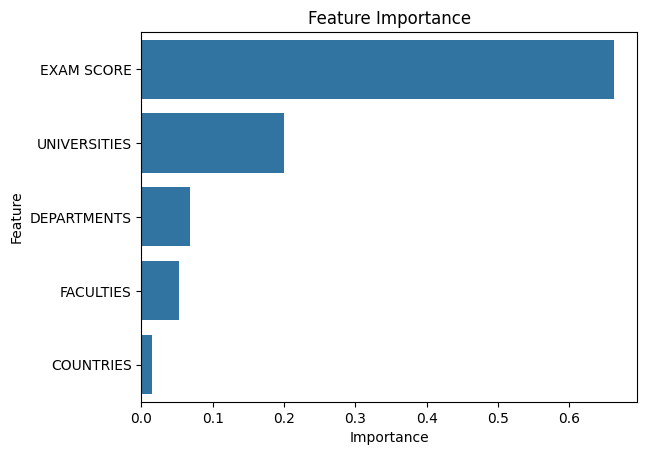

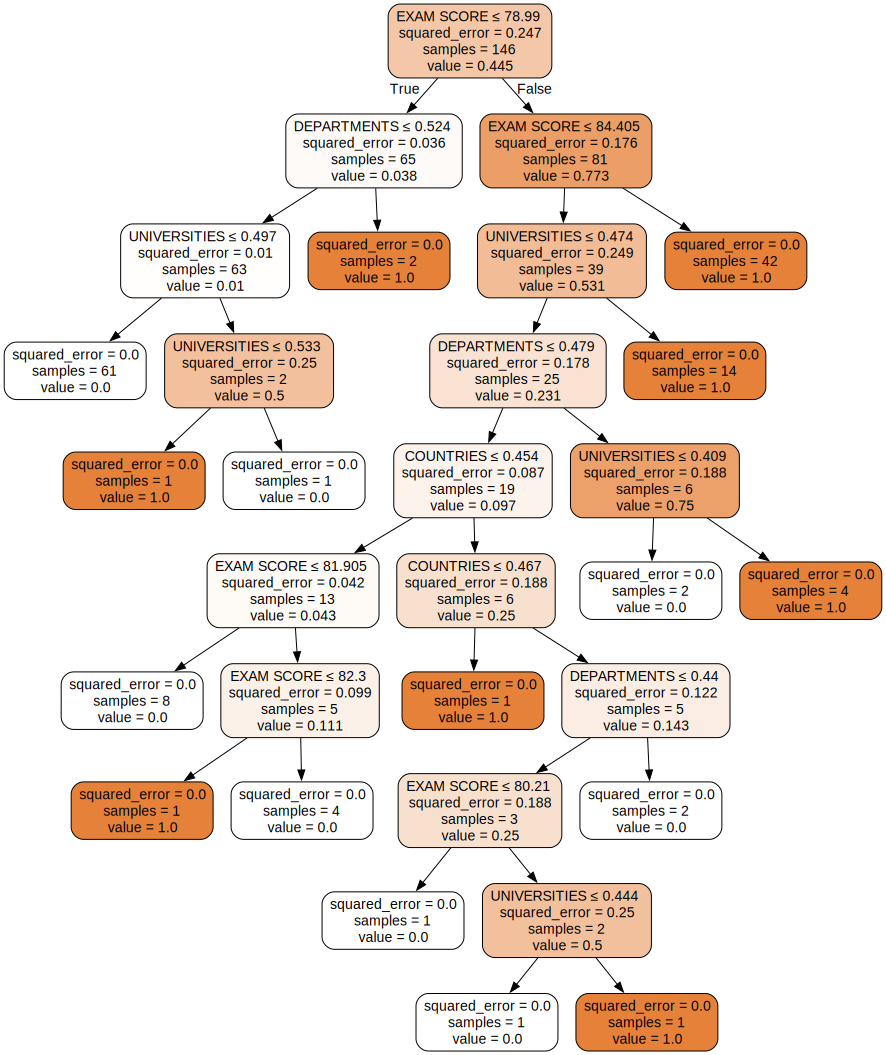

In [17]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=777), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
run_experiment(X_train, X_test, y_train, y_test, best_params, "Hyperparameter Tuned-Model")